In [7]:
import itertools

import matplotlib.pyplot as plt
from   matplotlib import ticker
import numpy as np
import pandas as pd
from   sklearn.metrics import confusion_matrix
from   sklearn.model_selection import train_test_split
import tensorflow as tf
from   tensorflow.keras import Model
from   tensorflow.keras.layers import Dense, Input
import tensorflow_datasets as tfds
from   tqdm import tqdm

In [2]:
train, info = tfds.load('fashion_mnist', split='train', with_info=True)
test = tfds.load('fashion_mnist', split='test')
class_names = ['T-shirt/top', 'Pants', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [3]:
def format_img(data):
    img = data['image']
    img = tf.reshape(img, [-1])
    img = tf.cast(img, 'float32')
    img = img / 255.
    return img, data['label']

In [4]:
train, test = [x.map(format_img) for x in [train, test]]

In [5]:
BATCH = 64
BUFFER = 1024

In [6]:
train = train.shuffle(buffer_size=BUFFER).batch(BATCH)
test = test.batch(batch_size=BATCH)

In [8]:
def base_mod():
    inputs = Input(shape=(784,), name='digits')
    X = Dense(64, activation='relu', name='D1')(inputs)
    X = Dense(64, activation='relu', name='D2')(X)
    outputs = Dense(10, activation='softmax', name='preds')(X)
    mod = Model(inputs=inputs, outputs=outputs)
    return mod

In [12]:
optim = tf.keras.optimizers.Adam()
get_loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [11]:
train_acc_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
val_acc_metric = tf.keras.metrics.SparseCategoricalCrossentropy()

In [13]:
def apply_grad(optim, mod, X, y):
    with tf.GradientTape() as t:
        logits = mod(X)
        loss =  get_loss(y_true=y, y_pred=logits)
    grads = t.gradient(loss, mod.trainable_weights)
    optim.apply_gradients(zip(grads, mod.trainable_weights))
    return logits, loss

In [20]:
def train_epoch():
    losses = []
    pbar = tqdm(total=len(list(enumerate(train))), 
                position=0, 
                leave=True, 
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} ')
    for step, (X_batch, y_batch) in enumerate(train):
        logits, loss = apply_grad(optim, mod, X_batch, y_batch)
        losses.append(loss)
        train_acc_metric(y_batch, logits)
        pbar.set_description(f'Training loss for step {step}: {loss:.4f}')
        pbar.update()
    return losses

In [21]:
def validate():
    losses = []
    for X, y in test:
        logits = mod(X)
        loss = get_loss(y_true=y, y_pred=logits)
        losses.append(loss)
        val_acc_metric(y, logits)
    return losses

In [22]:
EPOCHS = 10

mod = base_mod()
val_losses, train_losses = [], []
for i in range(EPOCHS):
    print(f'Epoch {i}:', end=' ')
    loss_train = train_epoch()
    acc_train = train_acc_metric.result()
    loss_val = validate()
    acc_val = val_acc_metric.result()
    train_losses.append(np.mean(loss_train))
    val_losses.append(np.mean(loss_val))
    print(f'Train loss: {train_losses[-1]}, Val loss: {val_losses[-1]}')
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()

Epoch 0: 

Training loss for step 937: 0.4260: 100%|██████████| 938/938 

Train loss: 0.5329715609550476, Val loss: 0.4286866784095764
Epoch 1: 


Training loss for step 937: 0.1213: 100%|█████████▉| 937/938 

Train loss: 0.3869134485721588, Val loss: 0.3866068124771118
Epoch 2: 

Training loss for step 937: 0.2873: 100%|██████████| 938/938 

Train loss: 0.34794753789901733, Val loss: 0.3804185092449188
Epoch 3: 


Training loss for step 937: 0.2748: 100%|██████████| 938/938 


Train loss: 0.3236325979232788, Val loss: 0.3730868101119995
Epoch 4: 

Exception ignored in: <function tqdm.__del__ at 0x7f90228c81f0>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/std.py", line 1143, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tqdm/std.py", line 1272, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'
Training loss for step 937: 0.1213: 100%|██████████| 938/938 
Training loss for step 937: 0.1981: 100%|██████████| 938/938 

Train loss: 0.3088153004646301, Val loss: 0.36588847637176514
Epoch 5: 


Training loss for step 937: 0.3980: 100%|█████████▉| 937/938 

Train loss: 0.2932245433330536, Val loss: 0.3645918667316437
Epoch 6: 

Training loss for step 937: 0.2469: 100%|█████████▉| 937/938 

Train loss: 0.2835500240325928, Val loss: 0.34679949283599854
Epoch 7: 

Training loss for step 937: 0.2469: 100%|██████████| 938/938 
Training loss for step 937: 0.2505: 100%|██████████| 938/938 


Train loss: 0.2739180624485016, Val loss: 0.34918415546417236
Epoch 8: 

Training loss for step 937: 0.1325: 100%|█████████▉| 937/938 

Train loss: 0.2641352117061615, Val loss: 0.36420685052871704
Epoch 9: 

Training loss for step 937: 0.1325: 100%|██████████| 938/938 
Training loss for step 937: 0.2400: 100%|██████████| 938/938 

Train loss: 0.25690481066703796, Val loss: 0.3572276830673218


In [24]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.plot(train_metric, color='blue', label=metric_name)
    plt.plot(val_metric, color='red', label=f'val_{metric_name}')
    plt.legend()

Training loss for step 937: 0.2400: 100%|██████████| 938/938 


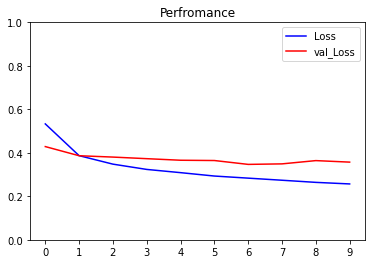

In [25]:
plot_metrics(train_losses, val_losses, 'Loss', 'Perfromance', 1.)